In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')



from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score



from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, precision_score,recall_score


import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## Print dataset to have a general knowledge on what i am working

In [18]:
dataset = pd.read_csv("term-deposit-marketing-2020.csv")
dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


## Describe the dataset and check for misssing values. 




In [19]:
print(dataset.describe())
print(f"\nMissing data in the dataset: {dataset.isnull().values.sum()}\n")


                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

Missing data in the dataset: 0



In [20]:
#dataset["y"] = dataset["y"].replace({'yes':1, 'no':0})
print(f"Response variable count for original dataset:\n{dataset['y'].value_counts()}")
print("\nThere is class imbalance so if fix it with the method mentioned above:\n")

Response variable count for original dataset:
no     37104
yes     2896
Name: y, dtype: int64

There is class imbalance so if fix it with the method mentioned above:



## I continue by checking the response value imbalance.
If there is an imbalance ill perform Random Undersampling 
in order to balance the  the dataset in order to avoid bias


In [21]:
print(f"Response variable count for original dataset:\n{dataset['y'].value_counts()}")
print("\nThere is class imbalance so if fix it with the method mentioned above:\n")

yes = dataset[dataset.y == "yes"]
no = dataset[dataset.y == "no"].sample(n=yes.shape[0], random_state=32)

balanced_dataset = pd.concat([yes, no])

print(f"Response variable count for the balanced dataset:\n{balanced_dataset['y'].value_counts()}")


Response variable count for original dataset:
no     37104
yes     2896
Name: y, dtype: int64

There is class imbalance so if fix it with the method mentioned above:

Response variable count for the balanced dataset:
no     2896
yes    2896
Name: y, dtype: int64


# I continue with some data exploration 


Text(0.5, 1.0, 'Balanced job,y count')

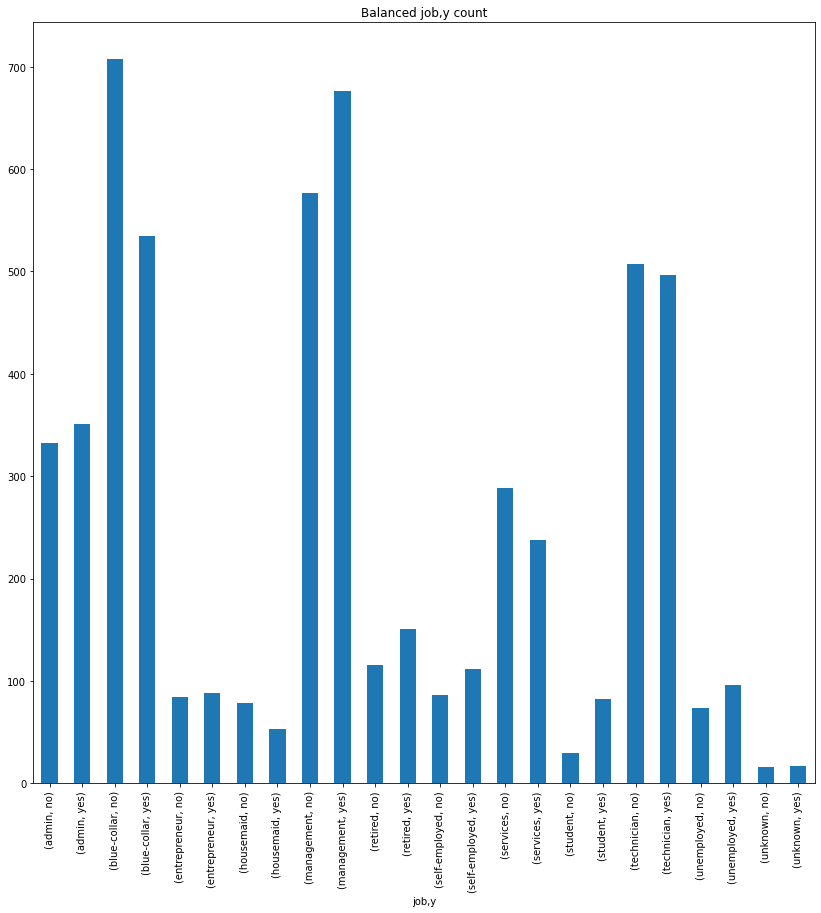

In [22]:
plt.figure(figsize=(14,14))
df_plot = balanced_dataset.groupby(['job','y']).y.count().plot.bar()
plt.title("Balanced job,y count")


###  * Admin job, student, self-employed churn more to subscription
###  * Blue-collar, services churn less to subscribtion

Text(0.5, 1.0, 'Balanced month,y count')

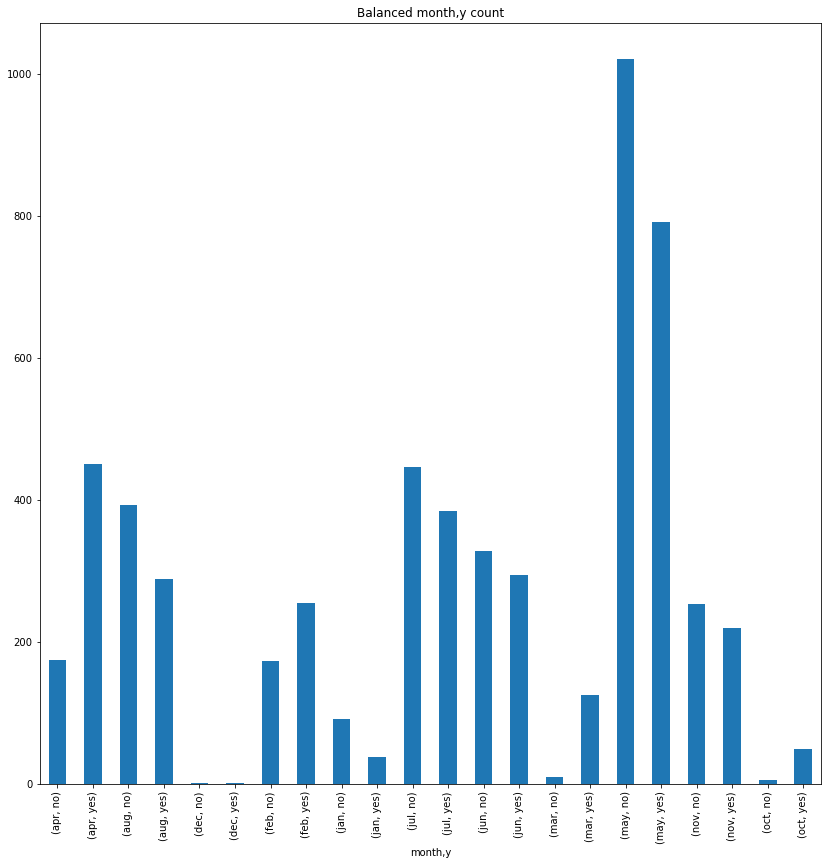

In [23]:
plt.figure(figsize=(14,14))
df_plot = balanced_dataset.groupby(['month','y']).y.count().plot.bar()
plt.title("Balanced month,y count")

###  * April, February, March, and October churn people more to subscription
###  * August,May, January churn less to subscribtion

Text(0.5, 1.0, 'Balanced housing,y count')

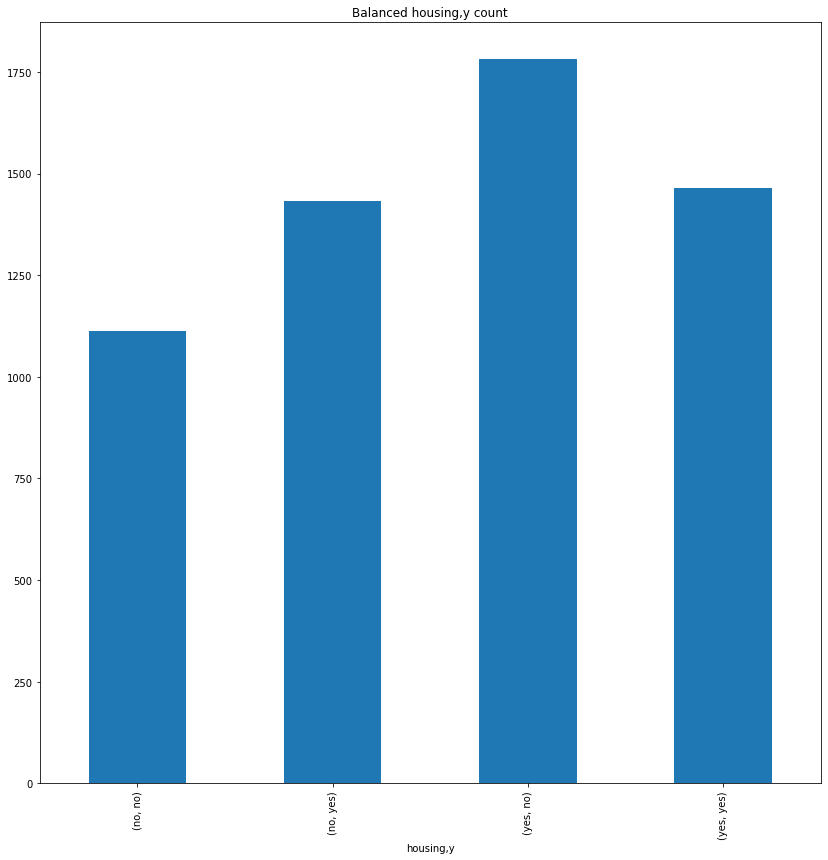

In [24]:
plt.figure(figsize=(14,14))
df_plot = balanced_dataset.groupby(['housing','y']).y.count().plot.bar()
plt.title("Balanced housing,y count")

###  * People with no housing churn to  subscribtion more
###  * People with housing churn to subscribtion less

Text(0.5, 1.0, 'Balanced marital,y count')

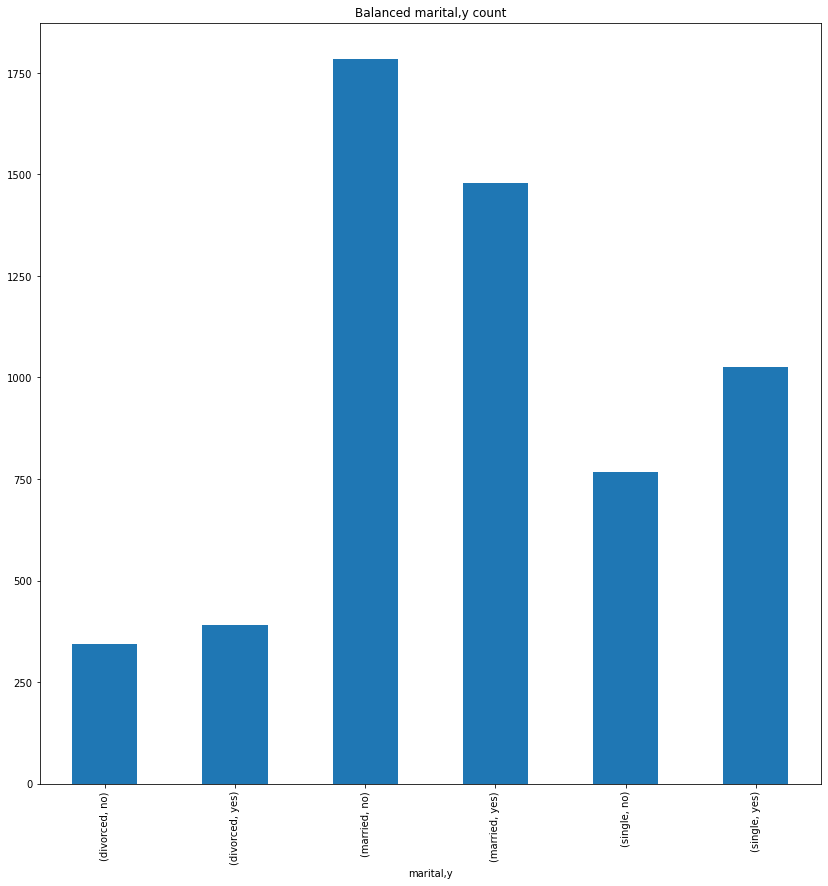

In [25]:
plt.figure(figsize=(14,14))
df_plot = balanced_dataset.groupby(['marital','y']).y.count().plot.bar()
plt.title("Balanced marital,y count")

### More married people dont subscribe than dont subscribe whereas more single people subscribe more.


###
###


# In general,  married people, with managerial jobs and without houses tend to churn more to subscribtions. Moreover,
# the data suggest that there is a positive churn in the months of April, February and March.

### This information can be used by the company to targed the  married people more than singles or divorced
### or to offer promotions in the other months to increse the positive churn.










### I will move on with model training

In [26]:

# Assign dummy variables to categorical types and
# split the features  from the response variable


X=pd.get_dummies(balanced_dataset.iloc[:,:-1]) 
y = balanced_dataset.iloc[:,-1:]


In [27]:
# I continued the  model training by firstly splitting the data in train and test datasets
X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,test_size=0.2,random_state=0)

print(f"Train dataset size is {X_train.shape[0]} and feature size is {X_train.shape[1]}")
print(f"Test dataset is {X_test.shape[0]} and feature size is {X_test.shape[1]}")



Train dataset size is 4633 and feature size is 44
Test dataset is 1159 and feature size is 44


### I use three different models to train: DecissionTreeClassifier, RandomForestClassifier, XGBClassifier
### There are  a lot of models to chose but  i prefered these due to the small (now balanced) dataset.
### I do a GridSearchCV to find the best parameters for each model and  have used five different metrics
### to check for model robustness.



### All proposed models pass the accuaracy score proposed by the competition


### RandomForestClassifier and XGBoost may take some time to find the best parameters.
### I present some results i took from my own experiments

# DecisionTreeClassifier & RandomForestClassifier

In [32]:
clf2 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()    

pipe2 = Pipeline([['sc',StandardScaler()],['clf2',clf2]])
pipe4 = Pipeline([['sc',StandardScaler()],['clf4',clf4]])

params_1 = {"clf1__C":[0.001,0.01,0.1,1,10,100,1000], "clf1__penalty":["l1","l2"]}# l1 lasso l2 ridge
params_2 = {'clf2__criterion':['gini','entropy'],'clf2__max_depth':[4,5,6,10,11,12,30,40,120,150]}
params_4 = {'clf4__n_estimators': [200, 700],'clf4__max_features': ['auto', 'sqrt', 'log2'],'clf4__min_samples_leaf': [1, 2, 4], 'clf4__min_samples_split': [2, 5, 10]}


clf_labels = [ "Decision Tree" ,"RandomForestClassifier"]

cv = KFold(n_splits=5, random_state=1, shuffle=True)

print("5-fold cross-validation:\n")


precision = make_scorer(precision_score, pos_label="yes")
recall = make_scorer(recall_score, pos_label="yes")



for clf,params,label in zip([pipe2,pipe4],[params_2,params_4],clf_labels):
    
    grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=0,cv=5)
    grid_search.fit(X_train, y_train.ravel())
    
    print(label)
    print("----------")
    print ('Best score: %0.3f' % grid_search.best_score_)
    print ('Best parameters set:')
    best_parameters = grid_search.best_params_
    
    
    for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r'%(param_name,best_parameters[param_name]))
        
  
    scores_test_f1  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="f1_macro")
    scores_test_roc  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="roc_auc")
    scores_test_accuracy  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="accuracy")
    scores_test_precision  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring=precision)
    scores_test_recall  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring=recall)

    print("\n")
    
    print(f"{label:20} precision: {scores_test_precision.mean() :.3f}")      
    print(f"{label:20} recall: {scores_test_recall.mean() :.3f}")  
    print(f"{label:20} f1       score: {scores_test_f1.mean():.3f}")
    print(f"{label:20} ROC-AUC  score: {scores_test_roc.mean() :.3f}")
    print(f"{label:20} accuracy score: {scores_test_accuracy.mean() :.3f}")
    print(" ")

5-fold cross-validation:

Decision Tree
----------
Best score: 0.861
Best parameters set:
	clf2__criterion: 'gini'
	clf2__max_depth: 5


Decision Tree        precision: 0.847
Decision Tree        recall: 0.790
Decision Tree        f1       score: 0.828
Decision Tree        ROC-AUC  score: 0.863
Decision Tree        accuracy score: 0.829
 
RandomForestClassifier
----------
Best score: 0.892
Best parameters set:
	clf4__max_features: 'sqrt'
	clf4__min_samples_leaf: 1
	clf4__min_samples_split: 10
	clf4__n_estimators: 200


RandomForestClassifier precision: 0.837
RandomForestClassifier recall: 0.869
RandomForestClassifier f1       score: 0.855
RandomForestClassifier ROC-AUC  score: 0.914
RandomForestClassifier accuracy score: 0.850
 


# XGBoost

In [36]:

clf5 = xgb.XGBClassifier(eval_metric='logloss')


pipe5 = Pipeline([['sc',StandardScaler()],['clf5',clf5]])


params_5 = {'clf5__max_depth': [2, 7, 10], 'clf5__n_estimators': [10, 100]}


clf_labels = [ "XGBoost"]

cv = KFold(n_splits=5, random_state=1, shuffle=True)

print("5-fold cross-validation:\n")


precision = make_scorer(precision_score, pos_label="yes")
recall = make_scorer(recall_score, pos_label="yes")



for clf,params,label in zip([pipe5],[params_5],clf_labels):
    
    grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=0,cv=5)
    grid_search.fit(X_train, y_train.ravel())
    
    print(label)
    print("----------")
    print ('Best score: %0.3f' % grid_search.best_score_)
    print ('Best parameters set:')
    best_parameters = grid_search.best_params_
    
    
    for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r'%(param_name,best_parameters[param_name]))
        
  
    scores_test_f1  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="f1_macro")
    scores_test_roc  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="roc_auc")
    scores_test_accuracy  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring="accuracy")
    scores_test_precision  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring=precision)
    scores_test_recall  = cross_val_score(estimator=clf.set_params(**grid_search.best_params_), X=X_test,y=y_test.ravel(),cv=cv,scoring=recall)

    print("\n")
    
    print(f"{label:20} precision: {scores_test_precision.mean() :.3f}")      
    print(f"{label:20} recall: {scores_test_recall.mean() :.3f}")  
    print(f"{label:20} f1       score: {scores_test_f1.mean():.3f}")
    print(f"{label:20} ROC-AUC  score: {scores_test_roc.mean() :.3f}")
    print(f"{label:20} accuracy score: {scores_test_accuracy.mean() :.3f}")
    print(" ")

5-fold cross-validation:

XGBoost
----------
Best score: 0.892
Best parameters set:
	clf5__max_depth: 10
	clf5__n_estimators: 100


XGBoost              precision: 0.841
XGBoost              recall: 0.862
XGBoost              f1       score: 0.853
XGBoost              ROC-AUC  score: 0.908
XGBoost              accuracy score: 0.853
 
